In [79]:
import pandas as pd
import numpy as np
import itertools  
import scipy.stats

In [81]:
df=pd.read_csv('C:\\Study\\Statistics\\Week4\\churn_analysis.csv')
df=df.drop(df.columns[0], axis=1)
df['churn']=df['churn'].apply(lambda x: 1 if x=='True.' else 0)

In [82]:
df.shape

(3333, 22)

Рассмотрим всех пользователей из контрольной группы (treatment = 1). 
Для таких пользователей мы хотим проверить гипотезу о том, что штат абонента не влияет на то, 
перестанет ли абонент пользоваться услугами оператора. 

In [13]:
control=df[df['treatment']==1]

In [14]:
control.churn.value_counts() 

0    917
1    180
Name: churn, dtype: int64

In [62]:
state_churns=control.groupby(['state','churn'])[['churn']].count()
state_churns.columns=['tot']
state_churns=state_churns.reset_index( )
state_churns = pd.pivot_table(state_churns, values='tot', index=['state'],
                     columns=['churn'], fill_value=0).reset_index().set_index('state')
state_churns.columns=['churn_0','churn_1']


In [63]:
state_churns.head()

,churn_0,churn_1
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [64]:
pair_states=list(itertools.combinations(state_churns.index,2))

Воспользуемся критерием хи-квадрат:

In [65]:
lst_pvalues=[]
for item in pair_states:
    tab=np.array((state_churns.loc[item[0],['churn_0','churn_1']],
                  state_churns.loc[item[1],['churn_0','churn_1']]))
    _, p, _, _ =scipy.stats.chi2_contingency(tab, correction=False)
    lst_pvalues.append([item[0],item[1],p])

In [66]:
df_pvalues.head()

,state_1,state_2,pvalue
0,AK,AL,0.423999
1,AK,AR,0.098943
2,AK,AZ,0.963119
3,AK,CA,0.080491
4,AK,CO,0.230821


Уровни значимости оказались меньше, чем α=0.05:

In [67]:
df_pvalues=pd.DataFrame.from_records(lst_pvalues)
df_pvalues.columns=['state_1','state_2','pvalue']
df_pvalues[df_pvalues['pvalue']<0.05].shape[0]

34

Применение критерия xи-квадрат для этих данных не обосновано, потому что не выполняются условия,
при которых этот критерий дает правильные результаты.

Интерпретация числа достигаемых уровней значимости, меньших α=0.05, некорректна, 
поскольку не сделана поправка на множественную проверку гипотез.

Т.к. данных мало, то применим поправку Йетса на непрерывность. 

In [68]:
lst_pvalues=[]
for item in pair_states:
    tab=np.array((state_churns.loc[item[0],['churn_0','churn_1']],
                  state_churns.loc[item[1],['churn_0','churn_1']]))
    _, p, _, _ =scipy.stats.chi2_contingency(tab, correction=True)
    lst_pvalues.append([item[0],item[1],p])

In [69]:
df_pvalues=pd.DataFrame.from_records(lst_pvalues)
df_pvalues.columns=['state_1','state_2','pvalue']
df_pvalues[df_pvalues['pvalue']<0.05].shape[0]

0

Количество достигаемых уровней значимости, меньших, чем 0.05, в точности равно нулю. 
То есть поправка увеличила достигаемые уровни значимости настолько, что больше ни одно 
из значений достигаемого уровня значимости не попадает в диапазон от 0 до 0.05.

Достигаемые уровни значимости на наших данных, полученные с помощью критерия xи-квадрат 
с поправкой Йетса, в среднем получаются больше, чем соответствующие значения без поправки.

Посчитаем для каждой пары штатов, как и в первом задании, достигаемый уровень значимости 
с помощью точного критерия Фишера:

In [70]:
lst_pvalues=[]
for item in pair_states:
    tab=np.array((state_churns.loc[item[0],['churn_0','churn_1']],
                  state_churns.loc[item[1],['churn_0','churn_1']]))
    _, p=scipy.stats.fisher_exact(tab)
    lst_pvalues.append([item[0],item[1],p])

In [72]:
df_pvalues=pd.DataFrame.from_records(lst_pvalues)
df_pvalues.columns=['state_1','state_2','pvalue']
df_pvalues[df_pvalues['pvalue']<0.05].shape[0]

10

Точный критерий Фишера на наших данных дает значения достигаемого уровня значимости 
в среднем меньшие, чем xи-квадрат с поправкой Йетса, но значительно большие, чем xи-квадрат
без поправки.

Точный критерий Фишера всегда лучше, чем критерий xи-квадрат, потому что не использует 
аппроксимацию дискретного распределения непрерывным. Однако при увеличении размера выборки 
его преимущества по сравнению с критерем xи-квадрат уменьшаются, в пределе достигая нуля.

Рассмотрим пару признаков day_calls и mes_estim. Посчитаем корреляцию Пирсона между этими 
признаками на всех данных, ее значимость.

In [94]:
df[['day_calls','mes_estim']].head()

,day_calls,mes_estim
0,110,0.65
1,123,0.55
2,114,0.72
3,71,0.28
4,113,0.45


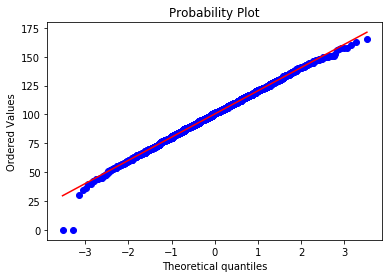

In [92]:
from scipy.stats import pearsonr, spearmanr
import pylab 
scipy.stats.probplot(df.day_calls, dist="norm", plot=pylab)
pylab.show()

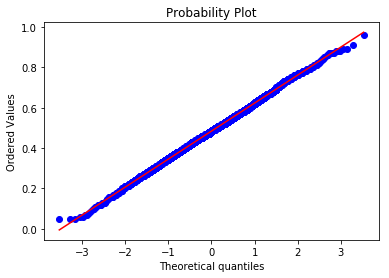

In [93]:
scipy.stats.probplot(df.mes_estim, dist="norm", plot=pylab)
pylab.show()

In [86]:
r, pvalue=scipy.stats.pearsonr(df.day_calls, df.mes_estim)
print('Pearson’s correlation coefficient: ',r,'p-value:', pvalue)

Pearson’s correlation coefficient:  -0.0517943505876 p-value: 0.00277988368698


Корреляция Пирсона имеет отрицательный знак, и отличие корреляции от нуля на уровне
доверия 0.05 значимо.

Посчитаем корреляцию Спирмена между этими признаками на всех данных, ее значимость.

In [114]:
r, pvalue=scipy.stats.spearmanr(df.day_calls, df.mes_estim)
print('Spearman’s correlation coefficient: ',r,'p-value:', pvalue)

Spearman’s correlation coefficient:  0.0433498805339 p-value: 0.0123173671892


Корреляция Спирмена имеет положительный знак, и отличие корреляции от нуля на уровне
доверия 0.05 значимо.

Не стоит ориентироваться на значение корреляции Спирмена, потому что корреляцию Спирмена 
можно считать только тогда, когда оба признака дискретные и между значениями можно установить 
строгий порядок.

Посчитанные корреляции и их значимости говорят лишь о том, что необходимо взглянуть на данные 
глазами и попытаться понять, что приводит к таким (противоречивым?) результатам.

Посчитаем значение коэффицента корреляции Крамера между двумя признаками: штатом (state) 
и оттоком пользователей (churn) для всех пользователей, которые находились в контрольной 
группе (treatment=1).

In [97]:
def cramers_stat(tab):
    chi2 = scipy.stats.chi2_contingency(tab)[0]
    n = tab.sum()
    return np.sqrt(chi2 / (n*(min(tab.shape)-1)))

In [103]:
df_treatment=df.loc[df['treatment']==1,['state','churn']]
state_churns=df_treatment.groupby(['state','churn'])[['churn']].count()
state_churns.columns=['tot']
state_churns=state_churns.reset_index( )
state_churns = pd.pivot_table(state_churns, values='tot', index=['state'],
                     columns=['churn'], fill_value=0).reset_index().set_index('state')
state_churns.columns=['churn_0','churn_1']

In [104]:
state_churns.head()

,churn_0,churn_1
state,,
AK,19,1
AL,25,5
AR,11,5
AZ,17,2
CA,10,5


In [107]:
cramers_stat(state_churns.values)

0.20039321502033319

In [111]:
_,p,_,_=scipy.stats.chi2_contingency(state_churns.values)
p

0.70975900427784733

Для вычисления коэффициента Крамера используется значение статистики xи-квадрат, 
на которую мы не можем положиться применительно к нашим данным (их мало и во многих
ячейках значение меньше 5)

Нужно провести анализ эффективности удержания (churn) с помощью раличных методов 
(treatment = 0, treatment = 2) относительно контрольной группы пользователей (treatment = 1).

In [115]:
df_1=df[df['treatment']==1]
df_0=df[df['treatment']==0]
df_2=df[df['treatment']==2]

In [118]:
def calc_p(df):
    return(np.sum(df.churn)/df.shape[0])
p1=calc_p(df_1)
p0=calc_p(df_0)
p2=calc_p(df_2)
n1=df_1.shape[0]
n0=df_0.shape[0]
n2=df_2.shape[0]

In [117]:
print(p1,p0,p2)

0.1640838650865998 0.14563106796116504 0.12511332728921123


In [120]:
def proportions_diff_confint_ind(p1,p2,n1,n2, alpha = 0.05):    
    z = scipy.stats.norm.ppf(1 - alpha / 2.)
    left_boundary = (p1 - p2) - z * np.sqrt(p1 * (1 - p1)/n1 + p2 * (1 - p2)/n2)
    right_boundary = (p1 - p2) + z * np.sqrt(p1 * (1 - p1)/n1+ p2 * (1 - p2)/n2)
    return (left_boundary, right_boundary)

In [121]:
print('P0: 95%% confidence interval for a difference between proportions: ', 
      proportions_diff_confint_ind(p1,p0,n1,n0, alpha = 0.05))
print('P2: 95%% confidence interval for a difference between proportions: ', 
      proportions_diff_confint_ind(p1,p2,n1,n2, alpha = 0.05))

P0:  (-0.011583241590025106, 0.04848883584089464)
P2:  (0.0096187667380921195, 0.068322308856685027)


In [125]:
def proportions_diff_z_stat_ind(p1,p2,n1,n2):
    P = float(p1*n1 + p2*n2) / (n1 + n2)   
    return (p1 - p2) / np.sqrt(P * (1 - P) * (1. / n1 + 1. / n2))

In [126]:
def proportions_diff_z_test(z_stat, alternative = 'two-sided'):
        return 2 * (1 - scipy.stats.norm.cdf(np.abs(z_stat)))

In [128]:
pvalue0=proportions_diff_z_test(proportions_diff_z_stat_ind(p1,p0,n1,n0))
pvalue2=proportions_diff_z_test(proportions_diff_z_stat_ind(p1,p2,n1,n2))
print('p-value P0:', pvalue0)
print('p-value P2:', pvalue2)

p-value P0: 0.228331163905
p-value P2: 0.00934808429445


In [132]:
from statsmodels.sandbox.stats.multicomp import multipletests 
reject, p_corrected, a1, a2 = multipletests([pvalue0,pvalue2],alpha = 0.05, method = 'holm')

In [133]:
p_corrected

array([ 0.22833116,  0.01869617])

Вьівод: treatment = 2 статистически значимо отличается от контрольной группы treatment = 1